In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# **Wavenet**

https://arxiv.org/abs/1609.03499

In [1]:
# read in all the wrods
words = open("makemore/names.txt", "r").read().splitlines()
len(words)

32033

In [2]:
#build the vocabulary of characters and ampping tofrom integers
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(["."] +chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi.items())


In [4]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [7]:
#build the dataset
# build the dataset
def build_dataset(words):
    block_size = 3 # how many chars do we take to predict the next one (context length)
    X, Y = [], []

    for w in words[:]:
        #print(w)
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context),"-->",itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    X.shape, Y.shape
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [15]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print("".join([itos[ix.item()] for ix in x]),"--->",itos[y.item()])

... ---> e
..e ---> l
.el ---> i
eli ---> a
lia ---> n
ian ---> y
any ---> s
nys ---> .
... ---> t
..t ---> r
.tr ---> o
tro ---> y
roy ---> .
... ---> m
..m ---> a
.ma ---> r
mar ---> k
ark ---> u
rku ---> s
kus ---> .


In [105]:
# Let's train and deeper Neural network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) * 1/(fan_in ** 0.5) #should technically a unifomr dist
        #self.weight = torch.zeros((fan_in,fan_out)) * 1/(fan_in ** 0.5) #change to zero and check how it trains
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) #[] adds nothing which [None] adds a none object
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True #pytroch nn modules have this attribute allow us to make hte module have a different behaviour in trianing vs evaluation 
        
        #parameters (trained with backprop)
        self.gamma  = torch.ones(dim) #bngain
        self.beta = torch.zeros(dim) #gnbias

        #buffers (trainig ith a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #calcualte forward pass
        #want to normalize across the rows of x

        if self.training == True:
            xmean = x.mean(dim = 0, keepdim = True)
            xvar = x.var(dim = 0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        #normalize layer
        xhat =  (x - xmean) / (xvar + self.eps)**0.5 
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad(): #context manager for efficiency :)
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        #return output
        return self.out #pytorch does not do a self.out - done to allow some inference, just retur d

    def parameters(self):
        return [self.gamma, self.beta]
    


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


In [104]:
torch.manual_seed(42);

In [106]:
n_embd = 10
block_size = 3
n_hidden = 200
g = torch.Generator().manual_seed(2147483547)

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confidence
    layers[-1].weight *= 0.1

    # #all other layers apply gain of tanh
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 #change this to 1 and then run the activation visualization funciton - CRAZY
    #         #makes so much sense - if linear layers no need out 1/sqrt(n would control)
    #         # but tanh is a squashing funciton so it will decrease the std and thus we need to add a gain to correct for this
    #         # thie gain must be depended on the input being standard normal - as teh amount of sqaushing would depedn on input to tanh
    #         #5/3 is a bit of a magic number hahaha

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [107]:
#same optimization as last time....
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update to data ratio

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) #random sample of indexes
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain graph
    for p in parameters:
        p.grad = None
    loss.backward() 

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().mean() for p in parameters])
    
    # if i > 1000:
    #     break #AFTER_DEBUG obviuoslt take this out


      0/ 200000: 3.3077
  10000/ 200000: 1.9337
  20000/ 200000: 2.1956
  30000/ 200000: 2.4348


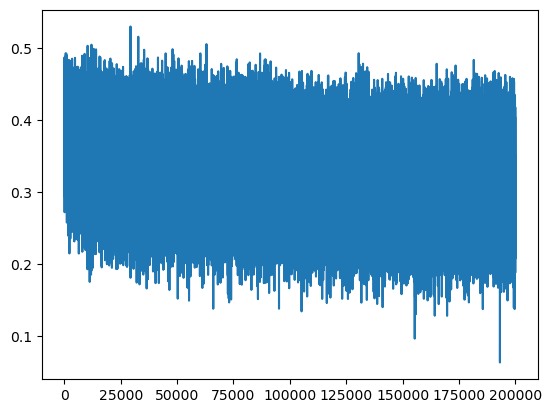

In [ ]:
plt.plot(lossi)

In [ ]:
# put layers into eval mode (needed for batchnorm expecially)
for layer in layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() #thie decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte,Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    x = emb.view(emb.shape[0],-1) # concat onto (N, block_size * n_emb)
    for layer in layers:
        print(layer.__class__.__name__,x)
        x = layer(x)
    loss = F.cross_entropy(x,y)
    print(split,loss.item())

split_loss("train")
split_loss("test")


Linear tensor([[ 0.6316,  0.7045, -0.3673,  ..., -0.4920, -0.4470,  1.4724],
        [ 0.6316,  0.7045, -0.3673,  ..., -0.0411, -0.0683,  1.3777],
        [ 0.6316,  0.7045, -0.3673,  ...,  0.4651,  2.1262,  1.7555],
        ...,
        [ 0.6316,  0.7045, -0.3673,  ..., -0.2369, -1.6943,  1.5607],
        [-0.1295,  1.2278, -0.9966,  ...,  2.1819,  0.1122,  0.6537],
        [-0.0133, -0.3760,  0.2651,  ...,  0.9134, -0.3007,  0.9671]])
BatchNorm1d tensor([[ 0.1454,  3.6432,  0.3486,  ..., -1.1514, -1.1960,  0.7877],
        [ 0.0232,  3.8295,  0.1423,  ..., -0.8499, -2.5463,  1.8279],
        [ 0.0825,  2.7661, -1.8510,  ...,  0.6932, -1.7260, -0.6085],
        ...,
        [-3.0739,  3.8695,  0.5954,  ..., -2.7908, -1.5237,  0.8270],
        [ 2.4698,  3.2096,  1.1572,  ...,  0.3295, -4.0609,  0.8603],
        [-0.9716,  4.3675, -2.9724,  ..., -0.4282,  2.7088, -1.2491]])


AttributeError: 'BatchNorm1d' object has no attribute 'running_std'

In [ ]:
# sample from hte model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0],-1)        
        for layer in layers: 
            #print(layer.__class__.__name__,x)       
            x = layer(x)       
        probs = F.softmax(x, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
          
    print("".join(out))


Linear tensor([[ 0.6316,  0.7045, -0.3673, -0.7819,  0.2537, -0.4930, -0.0282, -0.4920,
         -0.4470,  1.4724,  0.6316,  0.7045, -0.3673, -0.7819,  0.2537, -0.4930,
         -0.0282, -0.4920, -0.4470,  1.4724,  0.6316,  0.7045, -0.3673, -0.7819,
          0.2537, -0.4930, -0.0282, -0.4920, -0.4470,  1.4724]],
       grad_fn=<ViewBackward0>)
BatchNorm1d tensor([[ 0.1454,  3.6432,  0.3486,  0.4958,  0.7437, -0.0803,  0.2257, -0.8014,
         -0.4568,  1.6366,  2.8649,  0.8418, -0.1430,  0.9484,  0.3550, -1.2288,
         -0.9810, -0.5762,  2.4749, -0.9463, -1.0505,  0.3542,  0.4701,  0.6439,
         -1.1269, -0.2995, -0.7310, -1.0888,  1.4383, -0.3260, -1.7116, -0.9743,
         -2.0540,  2.7599,  0.8088,  4.0249, -0.6984, -0.9722, -0.3620,  1.0558,
         -0.1911, -1.4423, -0.5895,  0.4337, -1.2233,  0.6297,  1.7196,  1.1241,
          0.5899, -1.9114,  0.6511,  0.4559, -0.2662, -0.4802, -1.0160, -0.9209,
         -0.7801,  0.3723,  0.8447, -1.1061, -1.6603,  3.4685,  1.1633, -2

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

# **Network debug**

layer 2 (      Tanh): mean +0.00, std 0.64, saturated 3.20


Text(0.5, 1.0, 'activation distribution')

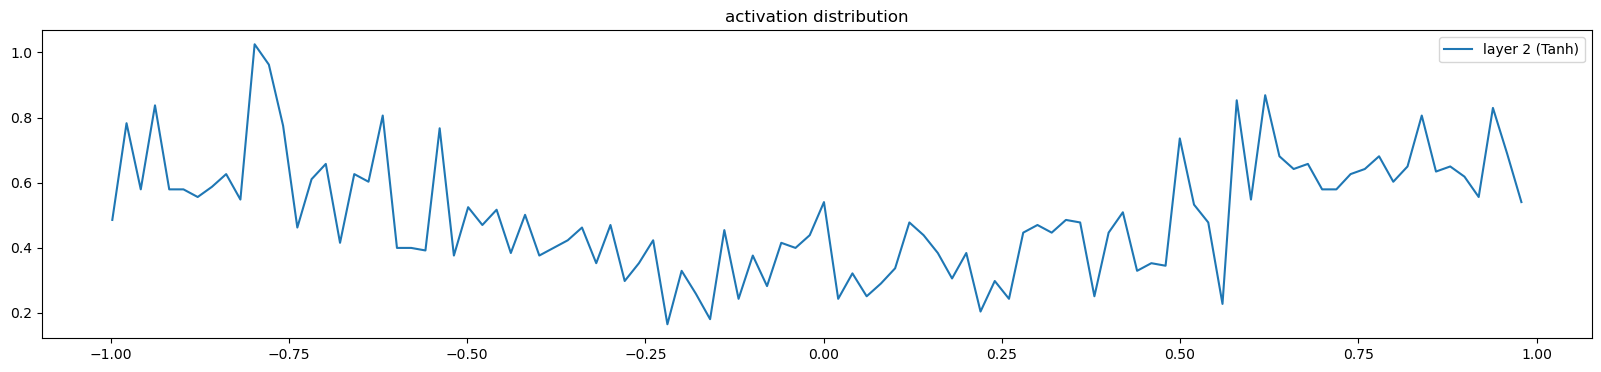

In [28]:
#visualize historgrams of foward pass activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out #this is why we need this
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100 ))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("activation distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

layer 2 (      Tanh): mean -0.000065, std 1.782548e-03


Text(0.5, 1.0, 'gradient distribution')

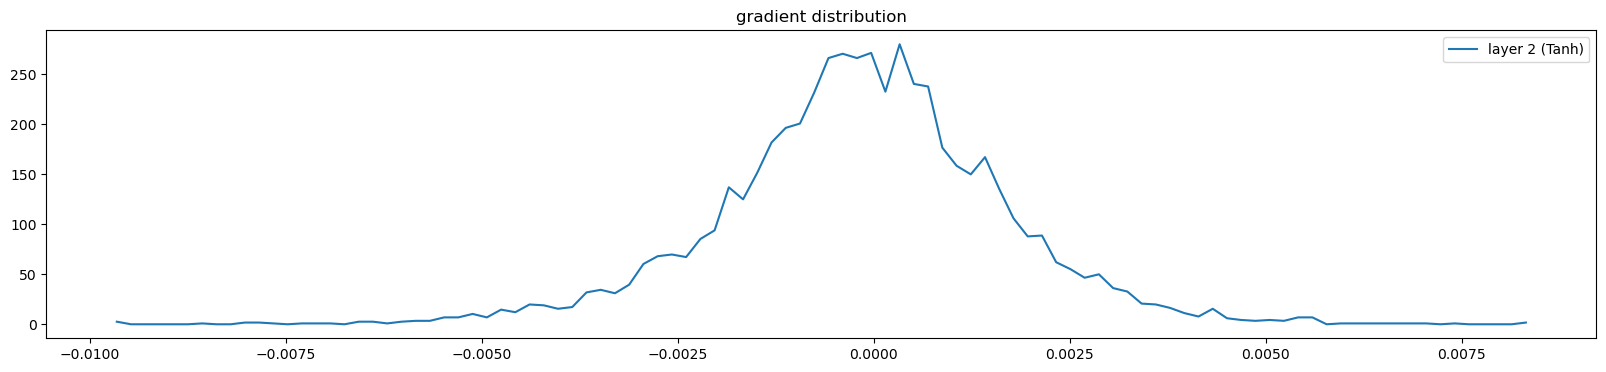

In [29]:
#visualize historgrams of gradients activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out.grad #this is why we need this
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("gradient distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

weight   (27, 10) | mean -0.000000 | std 9.157771e-03 | grad:data ratio 9.145946e-03
weight  (30, 200) | mean +0.000112 | std 7.799477e-03 | grad:data ratio 4.249698e-02
weight  (200, 27) | mean +0.000000 | std 1.920921e-02 | grad:data ratio 3.622825e-01


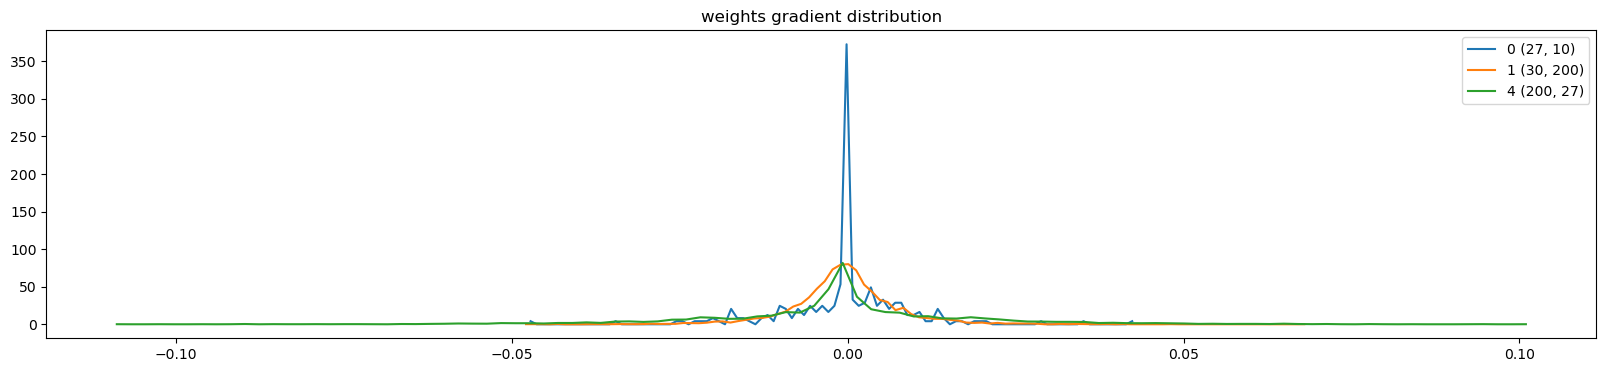

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad #gradient of the parameters
  p #the parameters themselves
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# grad:data rtaio
#Size of gradietn compared to size of parameter weights - want to take small steps .data vs .grad
# not true in last layer - whose gradients are 10x greater than all the other weights
# last layers is trained 10x faster
# Fixes itself if you train for a bit longer 

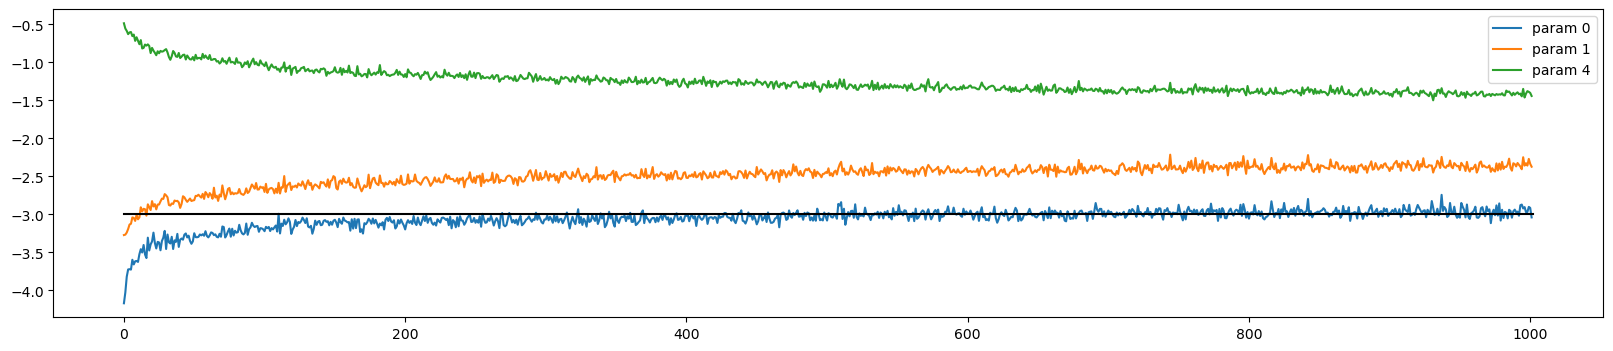

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Other